In [1]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
env = gym.make('Blackjack-v0')
env.reset()

(11, 10, False, True)

In [3]:
class Agent():
    def __init__(self, env, epsilon=1.0, gamma=0.99, num_episodes_to_train=30000, timestep=0):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        #self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.visits = dict()
        
        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        #self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        #self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        #self.num_episodes_to_train_left = num_episodes_to_train
        self.timestep = timestep
        
    def updateEpsilon(self):
        epsilonStart = 1
        epsilonEnd = 0
        scalingFactor = 100
        self.epsilon = epsilonStart + (epsilonEnd-epsilonStart)*np.exp(
                       (self.timestep-self.num_episodes_to_train)/scalingFactor)

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        '''
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0
        '''
        #self.timestep += 1
        if self.timestep <= self.num_episodes_to_train:
            self.updateEpsilon()
        else:
            self.epsilon = 0

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        # If not first round, double is not allowed
        if observation[3] == False:
            self.valid_actions = self.valid_actions[:2]
        else:
            self.valid_actions = list(range(self.env.action_space.n))

        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)
            self.visits[observation] = dict((action, 1) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)
        
        self.visits[observation][action] += 1
        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """
        
        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        alpha = 1/(1+self.visits[observation][action])
        self.Q[observation][action] = (1-alpha)*self.Q[observation][action] + (
                                      (alpha)*(reward+(self.gamma*self.get_maxQ(next_observation))))

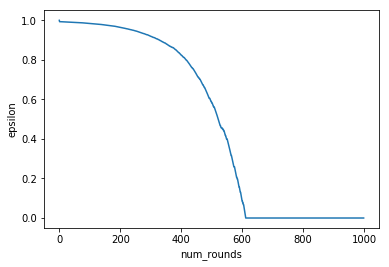

Average payout after 800 rounds is -302.5


In [4]:
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = []
agent = Agent(env=env, epsilon=1.0, gamma=0.9, num_episodes_to_train=500, timestep=0)

num_rounds = 800 # Payout calculated over num_rounds
num_samples = 1 # num_rounds simulated over num_samples


observation = env.reset()
for sample in range(num_samples):
    round = 1
    epsilon_values = []
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        epsilon_values.append(agent.epsilon)
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            agent.timestep += 1
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
            average_payouts.append(total_payout/(sample*num_rounds + round))

# Plot epsilon over rounds to show rate of its decrease
plt.figure(2)
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/(num_samples)))

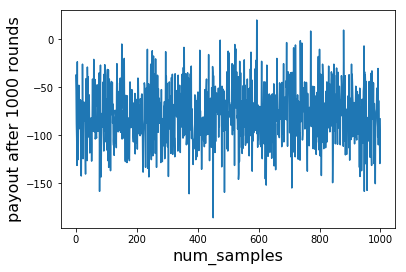

Average payout after 1000 rounds is -77.805


In [5]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Actions obtained from figure 11 here- https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done, __ = (env._get_obs())
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
        next_observation, payout, is_done, _ = env.step(action)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)           
plt.xlabel('num_samples',fontsize=16)
plt.ylabel('payout after 1000 rounds',fontsize=16)
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

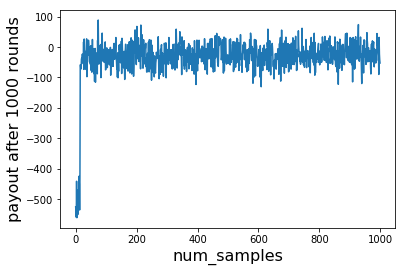

Average payout after 1000 rounds is -33.067


In [9]:
agent = Agent(env=env, epsilon=1.0, gamma=0.1, num_episodes_to_train=15000, timestep=0)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            agent.timestep += 1
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)           
plt.xlabel('num_samples',fontsize=16)
plt.ylabel('payout after 1000 rounds',fontsize=16)
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

In [7]:
learnedStrategy = open('AgentStrategy.txt','w')

In [8]:
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

payouts = []

observation = env.reset()
round = 1
total_payout = 0 # to store total payout over 'num_rounds'
# Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
while round <= num_rounds * num_samples:
    action = agent.choose_action(observation)
    next_observation, payout, is_done, _ = env.step(action)
    agent.learn(observation, action, payout, next_observation)
    payouts.append(payout)
    observation = next_observation
    if is_done:
        observation = env.reset() # Environment deals new cards to player and dealer
        round += 1

num_observations = 0        
list_players_hand = range(1, 22)
list_dealers_upcard = range(1, 11)

def readable_action(observation, agent):
    """ 
    Pass observation to agent and get human readable action
    H is hit, S is stick and '-' means the state is unseen and a random action is taken
    """
    if observation not in agent.Q:
        action = "-"
    else:
        strategy = agent.choose_action(observation)
        if strategy == 2:
            action = "D"
        elif strategy == 1:
            action = "H" 
        else:
            action = "S"    
    return action

# Print headers to give more information about output
learnedStrategy.write("{:^10} | {:^50} | {:^50}".format(
                      "Player's","Dealer's upcard when ace is not usable",
                      "Dealer's upcard when ace is usable"))
learnedStrategy.write("{0:^10} | {1} | {1}".format("Hand", [str(upcard) if not upcard==10 else 'A' 
                                                        for upcard in list_dealers_upcard]))
print (''.join(['-' for _ in range(116)]))
for players_hand in list_players_hand:
    actions_usable1 = []
    actions_not_usable1 = []
    for dealers_upcard in list_dealers_upcard:
        observation = (players_hand, dealers_upcard, False, True)
        actions_not_usable1.append(readable_action(observation, agent))
        
        observation = (players_hand, dealers_upcard, True, True)
        actions_usable1.append(readable_action(observation, agent))
    
    learnedStrategy.write("{:>10} | {} | {}\n".format(
                          players_hand, actions_not_usable1, actions_usable1))
    
learnedStrategy.write("Average payout after {} rounds is {}".format(
                       num_rounds, sum(payouts)/num_samples))

learnedStrategy.close()

--------------------------------------------------------------------------------------------------------------------
